# <font color=#323232>Playtika Project: Tweet Sentiment Prediction</font>

### <font color=#333333>1. Data | Libraries | Feature Extraction</font>
### <font color=#333333>2. Data Exploration & Data-Preprocessing</font>
### <font color=#333333>3. Feature Matrix</font>
### <font color=#333333>4. Tweet Classification</font>
#### <font color=#404040>&emsp;&emsp;4.1 Data Preparation</font>
#### <font color=#404040>&emsp;&emsp;4.2 Classification Models</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.1 Linear SVM Classifier with Stohastic Gradient Decent</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.2 Quadratic Discriminant Analysis with SVD</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.3 KNN</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.4 Feed-Forward Neural Network</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.5 Feed-Forward Neural Network - Tensorflow2.0</font>
#### <font color=#404040>&emsp;&emsp;4.3 Export Vectorizer and ML Model</font>


***

# 1. Import Libraries | Datasets

In [3]:
# Notebook created by Nikolaos Maroulis as part of the Technical Interview's case study

import pandas as pd
import numpy as np
import os, warnings
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import DataConversionWarning
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

warnings.filterwarnings(action='ignore', category=DataConversionWarning) # ignore some Scikit Learn warnings
pd.set_option("display.max_columns", None) # enables the printing of all columns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


raw_df = pd.read_csv('../datasets/tweet_emotions.csv')

# 2. Data Exploration & Data-Preprocessing

### Dataframe dimensions

In [4]:
if len(raw_df) > 0:
    print(f'Length of df {len(raw_df)}, number of columns {len(raw_df.columns)}, dimensions {raw_df.shape}, number of elements {raw_df.size}')
else:
    print(f'Problem loading df, df is empty.')

Length of df 40000, number of columns 3, dimensions (40000, 3), number of elements 120000


### Dataframe Overview

In [61]:
raw_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.7 MB


#### Statistics help us get some insights and allowes for an initial inspection of outliers 
##### In this case it is not very helpful

In [62]:
raw_df.describe(include='all')

,tweet_id,sentiment,content
count,4.000000e+04,40000,40000
unique,NaN,13,39827
top,NaN,neutral,I just received a mothers day card from my lovely daughter wishing my a happy mothers day http://tr.im/kWK9
freq,NaN,8638,14
mean,1.845184e+09,NaN,NaN
std,1.188579e+08,NaN,NaN
min,1.693956e+09,NaN,NaN
25%,1.751431e+09,NaN,NaN
50%,1.855443e+09,NaN,NaN
75%,1.962781e+09,NaN,NaN


In [63]:
raw_df.head(6)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends


### Handle Missing Values in Data
##### Note: Missing Data could be removed by:
    1) Removing the entire row that contains at least one Null Value
    2) Data Imputation - Fill the missing data with average/median of the column

In [64]:
print(raw_df.isna().sum())
print("No missing values after all :)")

tweet_id     0
sentiment    0
content      0
dtype: int64
No missing values after all :)


### Data Imputation
> Filling missing data, based on statistical operations from other values of the same column

**Note**: Data Imputation in this dataset is impossible since there are two significant rows

In [65]:
def data_imputation(df):
    
    nan_count = df.isna().sum().sum()

    df['sentiment'] = df['sentiment'].fillna("uknown")

    return

### Remove Duplication

In [3]:
df_size = len(raw_df)
raw_df.drop_duplicates(keep=False, inplace=True)
df_size_dup = len(raw_df)
print(f'Duplicate Rows Deleted {df_size - df_size_dup}, Old size: {df_size}, New size: {df_size_dup}')

Duplicate Rows Deleted 0, Old size: 40000, New size: 40000


### Show Columns that contain Numerical values
> **Note**: Columns that contain Numerical values can be Categorical

In [4]:
num_cols = raw_df._get_numeric_data().columns
print('Columns containing Numerical Values:\n', list(num_cols))
print('Columns containing non Numerical Values:\n', list(set(raw_df.columns) - set(num_cols)))

Columns containing Numerical Values:
 ['tweet_id']
Columns containing non Numerical Values:
 ['sentiment', 'content']


### Class Imbalance
> **Note**: Oversampling will be used later in order to balance the dataset

In [5]:
# Check label balance, count(unique(label))
print("Sentiment Label has", len(raw_df['sentiment'].unique()),"unique values.")
print(raw_df['sentiment'].value_counts())

Sentiment Label has 13 unique values.
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


### Content Column Character Count
> **Note**: Content texts below a given threshold (i.e. **word_count < 5**) will be considered **outliers**

In [5]:
# Create a column containing the Character Count
raw_df['content_char_count'] = raw_df['content'].str.len()

# Statistical Insights
raw_df['content_char_count'].describe() 

#  Remove the whole row, for samples that have a Chharacter count below 5
old_shape = raw_df.shape[0]
raw_df = raw_df[raw_df['content_char_count'] >= 5]
print(f'Rows Removed for having low number of characters: {old_shape-raw_df.shape[0]}')

Rows Removed for having low number of characters: 4


### Data Visualization

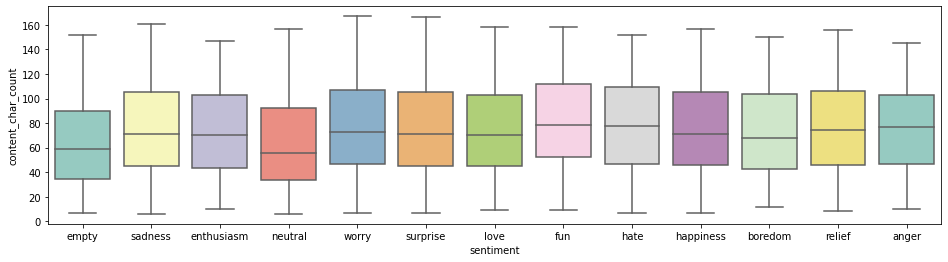

In [6]:
plt.figure(figsize=(16,4))
ax = sns.boxplot(x="sentiment",y="content_char_count",data=raw_df, palette="Set3")
plt.show()

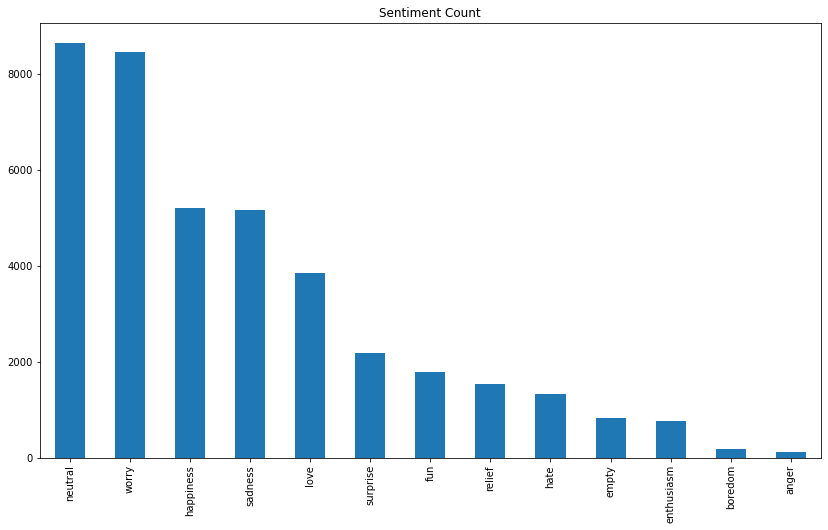

In [7]:
ax = raw_df['sentiment'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Sentiment Count")

### Encode Label
>    * Label Encoding - Encode Categorical Values with value between 0 and n_classes-1.
>    * Ordinal Encoding - Encode categorical features using an ordinal encoding scheme.
>    * **OneHot Encoding** - Encode categorical features as a one-hot numeric array.

In [72]:
# No Data Scaling/Normalization/Regularization is required

def categorical_data_encoding(df):

    le = preprocessing.LabelEncoder()

    return

# categorical_data_encoding(raw_df)

In [8]:
import re # Regex Library 

def replace_emoticons(txt):

    # Replace emoticons with a word describing the emoticon
    emoticons_happy = set([':-)', ':)', ':]', ':3', '=]', '=)'])

    emoticons_sad = set([':(',"=[" ,":'(", ':@', ':-(', ':[', ':-[', '>.<', ':-c',':c'])
    
    emoticons_surprised = set([':O', ':o', ':-o', ':-O'])

    words = txt.split()
    new_w = []
    for w in words:
        if w in emoticons_happy:
            new_w.append("happy")
        elif w in emoticons_sad:
            new_w.append("sad") 
        elif w in emoticons_surprised:
            new_w.append("surprised") 
        else:
            new_w.append(w)
    txt = " ".join(new_w)
    return txt


def data_cleaning(txt):
    txt = replace_emoticons(txt)     # replace emoticons with a word describing the emoticon
    txt = re.sub('@[^\s]+', '', txt) # remove usernames
    txt = re.sub('RT[\s]+', '', txt) # remove retweet 'RT'
    txt = re.sub('#', '', txt)       # remove '#'
    txt = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', txt)  # remove URLs inside the text
    # train_df['tokenized_content'] = train_df.apply(lambda row: row['content'].lower(), axis=1)

    return txt

print('Average word character count BEFORE data cleaning is',raw_df['content_char_count'].mean())
raw_df['content'] = raw_df['content'].apply(data_cleaning)
raw_df['content_char_count'] = raw_df['content'].str.len()
print('Average word character count AFTER data cleaning is',raw_df['content_char_count'].mean())

Average word character count BEFORE data cleaning is 73.41279127912792
Average word character count AFTER data cleaning is 66.1998699869987


In [9]:
# Perform the same operation as before and remove rows with Char Count <5
old_shape = raw_df.shape[0]
raw_df = raw_df[raw_df['content_char_count'] >= 5]
print(f'Rows Removed for having low number of characters: {old_shape-raw_df.shape[0]}')

Rows Removed for having low number of characters: 106


### Tweet Id and the Character count columns are redundant

In [10]:
raw_df = raw_df[['content','sentiment']]

In [11]:
pd.set_option('display.max_colwidth', None)
raw_df.head(5)

,content,sentiment
0,i know i was listenin to bad habit earlier and i started freakin at his part sad,empty
1,Layin n bed with a headache ughhhh...waitin on your call...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral


# 3. Feature Matrix Creation

> ### Implementations:
>    * Matrix Vectorization using **Bag of Words (BoW)** 
>        * Convert a collection of text documents to a matrix of token counts
>        * Ingore specific terms (i.e. stop words) because they don't hold any value
>        * Make every Character lowercase, because letter Capitalization doesn't matter in this specific implementation
>    * **Tf-idf Transformation**, in plain terms a word that occurs many times has less significance (weight) in the end result (i.e. the word 'the', 'a', 'to' etc.), following the zipf's law

**Note**: State-of-the-art Solutions like **RankNet**, **ListNET**, **LamdaRank**, **LambdaMART** etc., although they probably perform better, were not used in order to present a more custom solution

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('always')

# Bag of words Vectorizer
count_vect = CountVectorizer(analyzer='word', stop_words='english', lowercase=True)
tfidf_transformer = TfidfTransformer() # Tf-Idf Transformation
# TfIdf Vectorizer is both a vectorizer and a tfidf transformer
# Therefore TfidfVectorizer is Equivalent to CountVectorizer followed by TfidfTransformer.
tfidf_vectorizer = TfidfVectorizer(max_features=800, stop_words='english', lowercase=True, ngram_range=(1, 2),smooth_idf=False)

train_df = raw_df.copy()
print(train_df.shape[0])

39890


# 4. Tweet Classification
#### ***Model Training, HyperParameter Tuning and Evaluation***
> #### **Note**: 
>   * The Hyperparameter Tuning is performed using **Grid Search Optimization** 
>   * The main Evaluation Metric I tried to optimize was **accuracy**, F1-score and Recall, in order to avoid Underfit/Overfit
>   * **Cosine Similarity** could also be used to find similar tweets having >90% similarity and choose 


## 4.1 Data Preparation

### 4.1.1 Functions for train/test dataset split
>   * 10-fold Cross Validation

Note: The sklearn CV library could also be utilized, but a custom function is sometimes better

In [13]:
from sklearn.model_selection import train_test_split

def k_fold_cross_validation_metrics(model, model_name, k):
    """ten fold cross validation using the input model using sklearn metrics"""
    
    fold_size = int (np.size(train_df,0) / 10 ) 
    
    acc = []
    precision = []
    recall = []
    f1_sc = []
    
    for i in range(k):
        
        from_ = i*fold_size
        to_ = (i+1)*fold_size
        if i == k-1:
            to_ = train_df.shape[0]

        test_X = train_df['content'][from_:to_]    # Validation Set
        test_Y = train_df['sentiment'][from_:to_]
        train_set = train_df.drop(train_df.index[from_:to_])  # train_set = np.delete(train_df, np.s_[from_:to_], 0)
        train_X = train_set['content']
        train_Y = train_set['sentiment']
        _ = model.fit(train_X, train_Y)
        predicted = model.predict(test_X)
        
        precision.append(precision_score(test_Y, predicted, average='macro'))
        recall.append(recall_score(test_Y, predicted, average='macro'))
        acc.append(np.mean(predicted == test_Y))
        f1_sc.append(f1_score(test_Y, predicted, average='macro'))
        print(f'10-fold CV - Iteration, {i+1}/{k}')
    res = [[round(np.mean(acc),3), round(np.std(acc),3)],
           [round(np.mean(precision),3), round(np.std(precision),3)], 
           [round(np.mean(recall),3), round(np.std(recall),3)],
            [round(np.mean(f1_sc),3), round(np.std(f1_sc),3)]]
    print("Model Evaluation:", "\nAccuracy:", res[0][0]," - ", res[0][1]*100,"%", 
          "\nPrecision:", res[1][0]," - ",res[1][1]*100, "%", 
          "\nRecall:", res[2][0]," - ", res[2][1]*100, "%",
          "\nF1-score:", res[3][0]," - ", res[3][1]*100, "%")

    return res


def simple_split(model, model_name):
    """ 0.25 split for test data """
    
    X = train_df['content'].copy().values
    y = train_df['sentiment'].copy().values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    
    res = model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    result = np.mean(predicted == y_test)
    c_report = classification_report(y_test,predicted)
    print("<split> Accuracy Score for",model_name,"is",result)
    return res, c_report

### 4.1.2 OverSampling - Handle Class Imbalance

> Methods to be tested in order to select features:
> * Synthetic Minority Oversampling Technique (**SMOTE**)
>      * An algorithm that synthesizes elements for the minority class
>      * Removing the instances of the majority class of each pair increases the space between the two classes
> * **ADASYN** - generalized form of the SMOTE algorithm.
> * **SMOTE+TOMEK** is such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.
>      * After the oversampling is done by SMOTE, the class clusters may be invading each other’s space. 

**Note**: [**X_os, y_os**] contain the auugmented Data (after Oversampling) used for Training/Validation 


In [14]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

oversample = ADASYN(sampling_strategy='minority', random_state=8) # SMOTETomek(random_state=130)

final_vectorizer_params = {
    "smooth_idf": True,
    "analyzer": 'word',
    "stop_words": 'english',
    "lowercase": True,
    "ngram_range": (1,2),
    "max_features": 1200,
}

tf_idf_vec = TfidfVectorizer(**final_vectorizer_params)

X_os = train_df['content'].copy()
y_os = train_df['sentiment'].copy()

X_os = tf_idf_vec.fit_transform(X_os)

for i in range(11):
    X_os,y_os = oversample.fit_resample(X_os, y_os)

# print("Initial Class balance:",old_class_pop*100,", After SMOTE:", y_os.mean()*100)
print("New dataset shape",X_os.shape)

New dataset shape (114494, 1200)


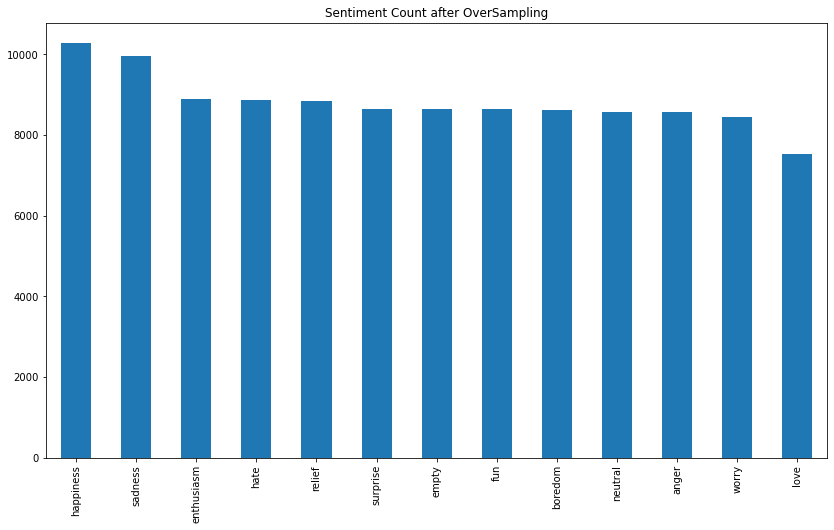

In [15]:
ax = y_os.value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Sentiment Count after OverSampling")

## 4.2 Classification Models

### 4.2.1 Linear SVM Classifier with Stohastic Gradient Decent
> **Note**: BoW and Tf-Idf is are used

In [28]:
"""
Linear SVM with Stohastic Gradient Decent with Bag of Words and Tf-Idf transformation on features.
"""

# Pipeline means that the following vectorization, transformation and model fit will be run in the following sequence
text_clf_svm = Pipeline([
    # ('vect', CountVectorizer(max_features=200, analyzer='word', stop_words='english', lowercase=True)),
    # ('tfidf', TfidfTransformer()),
    ('tfidf_trans', TfidfVectorizer()),
    ('svm', svm.SVC()),])


param_grid = {
    "tfidf_trans__smooth_idf": [True],
    "tfidf_trans__analyzer": ['word'],
    "tfidf_trans__stop_words": ['english'],
    "tfidf_trans__lowercase": [True],
    "tfidf_trans__ngram_range": [(1,2)],
    "tfidf_trans__max_features": [1200],
    "svm__kernel": ['linear'],
    "svm__C": [0.8],
    "svm__decision_function_shape": ['ovr'],
}


search = GridSearchCV(text_clf_svm, param_grid, n_jobs=-1, verbose=1)


res = simple_split(search, "SVM with SGD")

print("Best parameter (CV score=%0.3f):" % res[0].best_score_)
print(res[0].best_params_)

print(res[1])
# text_clf_svm_res = k_fold_cross_validation_metrics(text_clf_svm,'SVM with Stohastic Gradient Decent', 2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/nik/anaconda3/envs/sentiment_analysis_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nik/anaconda3/envs/sentiment_analysis_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nik/anaconda3/envs/sentiment_analysis_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

<split> Accuracy Score for SVM with SGD is 0.34593402185901934
Best parameter (CV score=0.345):
{'svm__C': 0.8, 'svm__decision_function_shape': 'ovr', 'svm__kernel': 'linear', 'tfidf_trans__analyzer': 'word', 'tfidf_trans__lowercase': True, 'tfidf_trans__max_features': 1200, 'tfidf_trans__ngram_range': (1, 2), 'tfidf_trans__smooth_idf': True, 'tfidf_trans__stop_words': 'english'}
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        19
     boredom       0.00      0.00      0.00        45
       empty       0.00      0.00      0.00       217
  enthusiasm       0.00      0.00      0.00       183
         fun       0.21      0.01      0.02       429
   happiness       0.33      0.40      0.36      1340
        hate       0.56      0.20      0.29       348
        love       0.48      0.37      0.42       943
     neutral       0.32      0.59      0.42      2114
      relief       0.29      0.05      0.08       375
     sadness       0.3

#### 4.2.1.1 Linear SVM Classifier with Stohastic Gradient Decent using ***Augmented Data***

In [52]:

final_model_params = {
    "kernel": 'linear',
    "C": 0.8,
    "decision_function_shape": 'ovr',
}

svm_model = svm.SVC(**final_model_params)


X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.25, random_state=42, shuffle=True)

    
svm_model.fit(X_train, y_train)

predicted = svm_model.predict(X_test)

result = np.mean(predicted == y_test)

print(classification_report(y_test,predicted))

print("<split> Accuracy Score for is",result)

              precision    recall  f1-score   support

       anger       0.47      1.00      0.64      2178
     boredom       0.73      0.77      0.75      2158
       empty       0.26      0.55      0.35      2150
  enthusiasm       0.39      0.47      0.43      2215
         fun       0.36      0.28      0.32      2147
   happiness       0.35      0.35      0.35      2583
        hate       0.53      0.39      0.45      2219
        love       0.49      0.35      0.41      1845
     neutral       0.24      0.15      0.18      2146
      relief       0.38      0.28      0.32      2215
     sadness       0.37      0.29      0.33      2486
    surprise       0.35      0.18      0.24      2164
       worry       0.32      0.21      0.25      2118

    accuracy                           0.40     28624
   macro avg       0.40      0.41      0.39     28624
weighted avg       0.40      0.40      0.39     28624

<split> Accuracy Score for is 0.4043110676355506


### 4.2.2 Quadratic Discriminant Analysis with SVD
> **Note**: BoW, Tf-Idf and SVD

In [ ]:
"""
Needs SVD because Matrix is too sparse
"""

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD


qda = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=2000)),
    ('qda', QuadraticDiscriminantAnalysis()),])


res = simple_split(qda,"QDA with SVD")
print(res)

### 4.2.3 KNN
> **Note**: BoW and Tf-Idf

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([
    ('tfidf_trans', TfidfVectorizer(stop_words='english',smooth_idf=False)),
    ('knn', KNeighborsClassifier(n_neighbors=3)),])


param_grid = {
    "tfidf_trans__smooth_idf": [True, False],
    "tfidf_trans__analyzer": ['word'],
    "tfidf_trans__lowercase": [True],
    "tfidf_trans__ngram_range": [(1, 1), (1,2),(1, 3)],
    "tfidf_trans__max_features": [300, 400, 800, 1000, 1200],
    "knn__n_neighbors": [15],
}

final_param_grid = {
    "tfidf_trans__smooth_idf": [True],
    "tfidf_trans__analyzer": ['word'],
    "tfidf_trans__lowercase": [True],
    "tfidf_trans__ngram_range": [(1,2)],
    "tfidf_trans__max_features": [400],
    "knn__n_neighbors": [15],
}


search = GridSearchCV(knn, final_param_grid, n_jobs=-1)


search = simple_split(search, "KNN")
print("Best parameter (CV score=%0.3f):" % search[0].best_score_)
print(search[0].best_params_)
print(search[1])

# <split> Accuracy Score for KNN is 0.2753275327532753
# Best parameter (CV score=0.272):

<split> Accuracy Score for KNN is 0.272836658979244
Best parameter (CV score=0.276):
{'knn__n_neighbors': 15, 'tfidf_trans__analyzer': 'word', 'tfidf_trans__lowercase': True, 'tfidf_trans__max_features': 400, 'tfidf_trans__ngram_range': (1, 2), 'tfidf_trans__smooth_idf': True}


### 4.2.4 Neural Network (Feed-Forward) - Sklearn

In [29]:
from sklearn.neural_network import MLPClassifier

"""
MLP Classifier
- Stohastic Gradient Decent
- RELU Activation function
- alpha: L2 penalty

"""

text_clf_mlp = Pipeline([
    ('tfidf_trans', TfidfVectorizer()),
    ('mlp', MLPClassifier()),])

lr_ = 0.003 # learning rate
l2_ = 0.001 # l2 penalty

param_grid = {
    "tfidf_trans__smooth_idf": [True],
    "tfidf_trans__analyzer": ['word'],
    "tfidf_trans__stop_words": ['english'],
    "tfidf_trans__lowercase": [True],
    "tfidf_trans__ngram_range": [(1,2)],
    "tfidf_trans__max_features": [1200],
    "mlp__hidden_layer_sizes": [(128,64,32 )],
    "mlp__activation": ['relu'],
    "mlp__solver": ['adam'],
    "mlp__alpha": [l2_],
    "mlp__batch_size": ['auto'],
    "mlp__learning_rate": ['constant'],
    "mlp__learning_rate_init": [lr_],
    "mlp__max_iter": [150],
}


search = GridSearchCV(text_clf_mlp, param_grid, n_jobs=-1, verbose=2)

res = simple_split(search, "Neural Network - MLP with BoW")

print("Best parameter (CV score=%0.3f):" % res[0].best_score_)
print(res[0].best_params_)

print(res[1])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
<split> Accuracy Score for Neural Network - MLP with BoW is 0.2621076907650657
Best parameter (CV score=0.261):
{'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__batch_size': 'auto', 'mlp__hidden_layer_sizes': (128, 64, 32), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.003, 'mlp__max_iter': 150, 'mlp__solver': 'adam', 'tfidf_trans__analyzer': 'word', 'tfidf_trans__lowercase': True, 'tfidf_trans__max_features': 1200, 'tfidf_trans__ngram_range': (1, 2), 'tfidf_trans__smooth_idf': True, 'tfidf_trans__stop_words': 'english'}
              precision    recall  f1-score   support

       anger       0.04      0.05      0.04        19
     boredom       0.09      0.04      0.06        45
       empty       0.01      0.00      0.01       217
  enthusiasm       0.01      0.01      0.01       183
         fun       0.09      0.10      0.09       429
   happiness       0.28      0.26      0.27      1340
        hate

### 4.2.5 Neural Network (Feed-Forward) using Tensorflow2.0

In [ ]:
# FEATURE_VECTOR_SIZE = len(train_df.columns) - 1  # exclude Label

# alpha = [0.05,0.95]
# EPOCHS = 6
# SAMPLE_THRESHOLD = 100
# VALIDATION_SPLIT = 0.25
# BATCH_SIZE = 128
# VERBOSE = 1


# keras_model = Sequential()
# keras_model.add(Dense(units=128, input_dim=FEATURE_VECTOR_SIZE,activation='relu'))
# keras_model.add(Dense(units=64,activation='relu'))
# keras_model.add(Dense(units=32, activation='relu'))
# keras_model.add(Dense(1, activation='softmax'))
# keras_model.compile(loss='categorical_crossentropy', optimizer='adam')

# """ Fit Data for Model"""
# X = X.astype(float).values
# y = y.values

# X = train_df.drop('prop_booking_bool', axis=1).copy().values
# Y = train_df['prop_booking_bool'].copy().values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 


# # """ One Hot Encode Label """
# # encoder = LabelEncoder()
# # encoder.fit(Y)
# # encoded_Y = encoder.transform(Y)
# # Y = tf.keras.utils.to_categorical(encoded_Y)

# # Y = Y.astype(np.float)
# X = np.asarray(X)
# X = X[:, np.newaxis]
# X = (X - X.mean())/X.std()

# with tf.device("gpu:0"):
#     history = keras_model.fit(X, Y, validation_split=VALIDATION_SPLIT, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE, shuffle=True) 


# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # # save_models(keras_model, c)
# # keras_model.predict(X)

## 4.3 Export Vectorizer and ML Model
> #### **Note**: Use the pickle library to export the Model and the Vectorizer in order to load them to the rest server

In [19]:
import pickle
from joblib import dump, load
from sklearn import svm


final_vectorizer_params = {
    "smooth_idf": True,
    "analyzer": 'word',
    "stop_words": 'english',
    "lowercase": True,
    "ngram_range": (1,2),
    "max_features": 1200,
}

final_model_params = {
    "kernel": 'linear',
    "C": 0.8,
    "decision_function_shape": 'ovr',
}

text_clf_svm = Pipeline([
    ('tfidf_trans', TfidfVectorizer(**final_vectorizer_params)),
    ('svm', svm.SVC(**final_model_params)),])

X = train_df['content'].copy().values
y = train_df['sentiment'].copy().values

text_clf_svm.fit(X,y)

# final_vectorizer = TfidfVectorizer(**final_vectorizer_params)
# final_vectorizer.fit(train_df['content'].astype('U'))

final_vectorizer = text_clf_svm['tfidf_trans']
final_model = text_clf_svm['svm']

### Export Model and Vectorizer trained by the Oversampled Data

In [16]:
# final model based on Oversampled dataset

final_model_params = {
    "kernel": 'linear',
    "C": 0.8,
    "decision_function_shape": 'ovr',
}

final_model = svm.SVC(**final_model_params)
final_model.fit(X_os, y_os)

# Save BoW Vectorizer and Tf-Idf Transformator to file 
with open('../models/vectorizer_tfidf-os.pickle', 'wb') as fin:
    pickle.dump(tf_idf_vec, fin)

# Save NLP Model to file
dump(final_model, '../models/SA_NLP_Model-os.joblib')

SVC(C=0.8, kernel='linear')

# TESTING